/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.6363636363636364

Confusion Matrix:
 [[34 11]
 [25 29]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.76      0.65        45
           1       0.72      0.54      0.62        54

    accuracy                           0.64        99
   macro avg       0.65      0.65      0.64        99
weighted avg       0.66      0.64      0.63        99



<ipython-input-2-b0323bef4b10>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='Importance', y='Feature', palette='crest')
<ipython-input-2-b0323bef4b10>:65: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


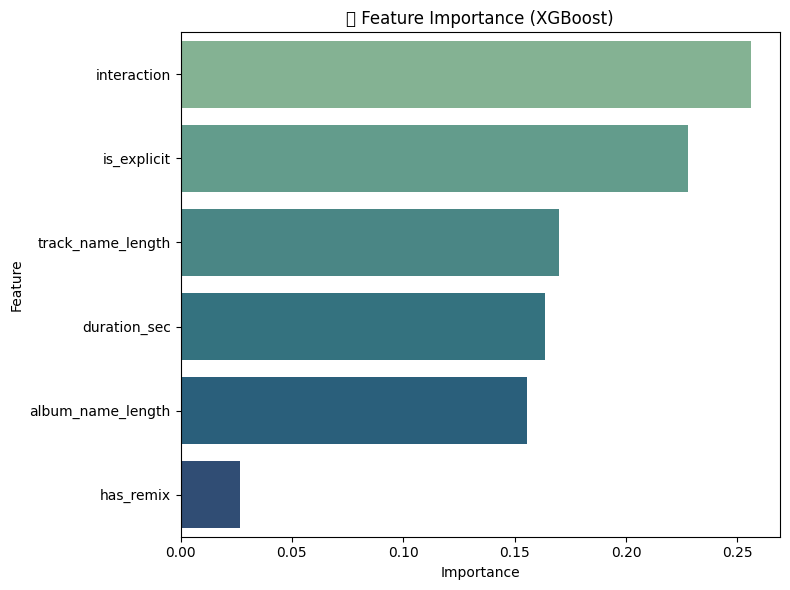

✅ XGBoost model saved.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import pickle

# === Load Data ===
tracks = pd.read_csv("/content/top_tracks.csv")
tracks = tracks.dropna(subset=['track_popularity', 'duration_ms'])

# === Binary Target ===
tracks['is_popular'] = tracks['track_popularity'].apply(lambda x: 1 if x >= 85 else 0)

# === Feature Engineering ===
tracks['duration_sec'] = tracks['duration_ms'] / 1000
tracks['track_name_length'] = tracks['track_name'].apply(lambda x: len(x))
tracks['album_name_length'] = tracks['album_name'].apply(lambda x: len(x))
tracks['has_remix'] = tracks['track_name'].str.lower().str.contains("remix").astype(int)
tracks['interaction'] = tracks['duration_sec'] * tracks['is_explicit'].astype(int)

# === Features and Target ===
features = ['duration_sec', 'track_name_length', 'album_name_length', 'is_explicit', 'has_remix', 'interaction']
X = tracks[features]
y = tracks['is_popular']

# === Feature Scaling ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Calculate Class Imbalance Ratio ===
pos_ratio = (y == 0).sum() / (y == 1).sum()

# === Train XGBoost Model ===
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=pos_ratio,
    max_depth=4,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === Evaluation ===
y_pred = xgb_model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === Feature Importance ===
importances = xgb_model.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='crest')
plt.title("🔥 Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# === Save Model ===
with open("xgb_tracks_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("✅ XGBoost model saved.")

